# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')

## Q1: Exploring Categories
- How many items in each category?
- What are the commonalities in category names - do they have any significance?

In [3]:
print("Length categories:", len(categories))
print("Category unique ids:", categories['item_category_id'].unique())

Length categories: 84
Category unique ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]


In [5]:
print("Length items:", len(items))
print("Items unique ids:", items['item_id'].unique())
print("Items category unique ids:", len(items['item_category_id'].unique()))
print("Items in train:", len(train['item_id'].unique()))

Length items: 22170
Items unique ids: [    0     1     2 ... 22167 22168 22169]
Items category unique ids: 84
Items in train: 21807


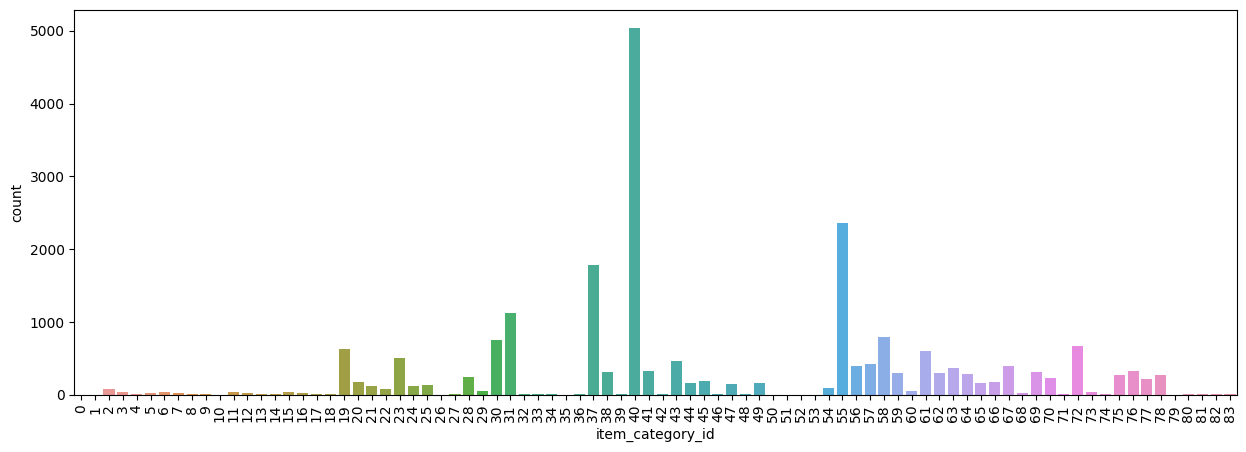

In [23]:
fig = plt.figure(figsize=(15,5))
sns.countplot(data=items, x='item_category_id')
plt.xticks(rotation=90);

,item_category_name,item_category_id
32,"Карты оплаты (Кино, Музыка, Игры)",32
42,"Книги - Артбуки, энциклопедии",42
47,"Книги - Комиксы, манга",47
62,"Подарки - Гаджеты, роботы, спорт",62


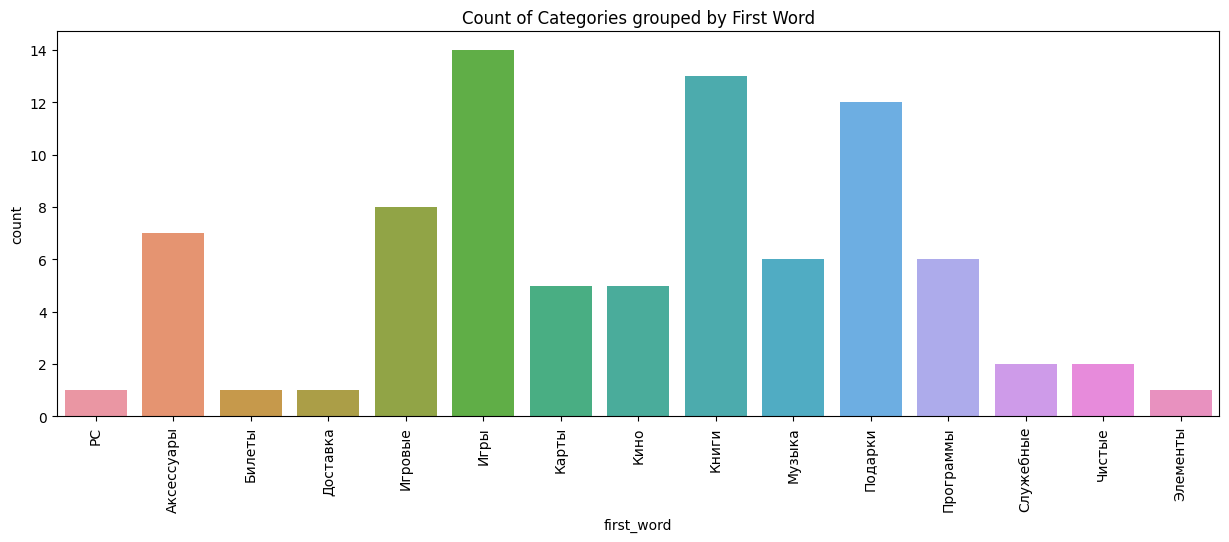

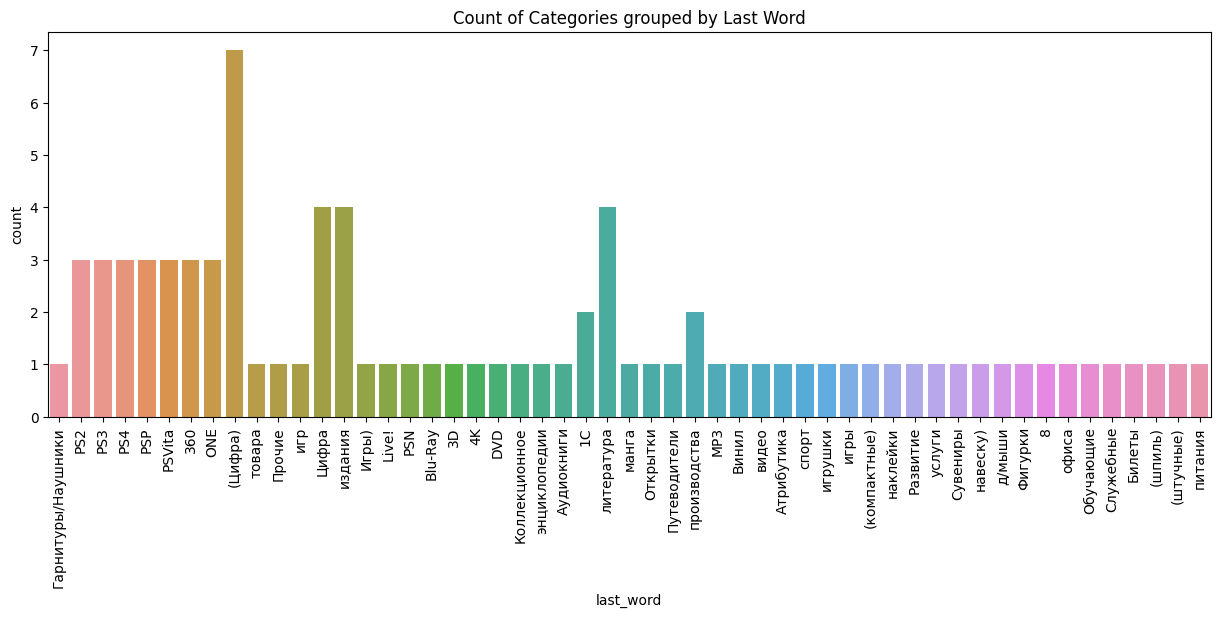

In [36]:
# Groupings
categories_cleaned = categories.copy()
categories_cleaned['item_category_name'] = categories_cleaned['item_category_name'].replace(r'\"', '', regex=True)
display(categories_cleaned.loc[[32,42,47,62],:]) # check if quotations are removed in select rows

fig = plt.figure(figsize=(15,5))
categories_cleaned['first_word'] = categories_cleaned['item_category_name'].str.split().str[0]
sns.countplot(data=categories_cleaned, x='first_word')
plt.xticks(rotation=90);
plt.title('Count of Categories grouped by First Word')
plt.show()

fig = plt.figure(figsize=(15,5))
categories_cleaned['last_word'] = categories_cleaned['item_category_name'].str.split().str[-1]
sns.countplot(data=categories_cleaned, x='last_word')
plt.xticks(rotation=90);
plt.title('Count of Categories grouped by Last Word')
plt.show()

Finding:

Many of the item categories are part of a broader category. This is why there are so many categories with the same first word.
For example, Аксессуары is accessories, Игровые консоли is game consoles.

Some of the item categories are related across groups. The last word groupings identify this.
Аксессуары - PS2 and Игровые - PS2 are different categories, but are related (accessories vs. game consoles, both for PS2).

# Q2: Shop commonalities & Groupings

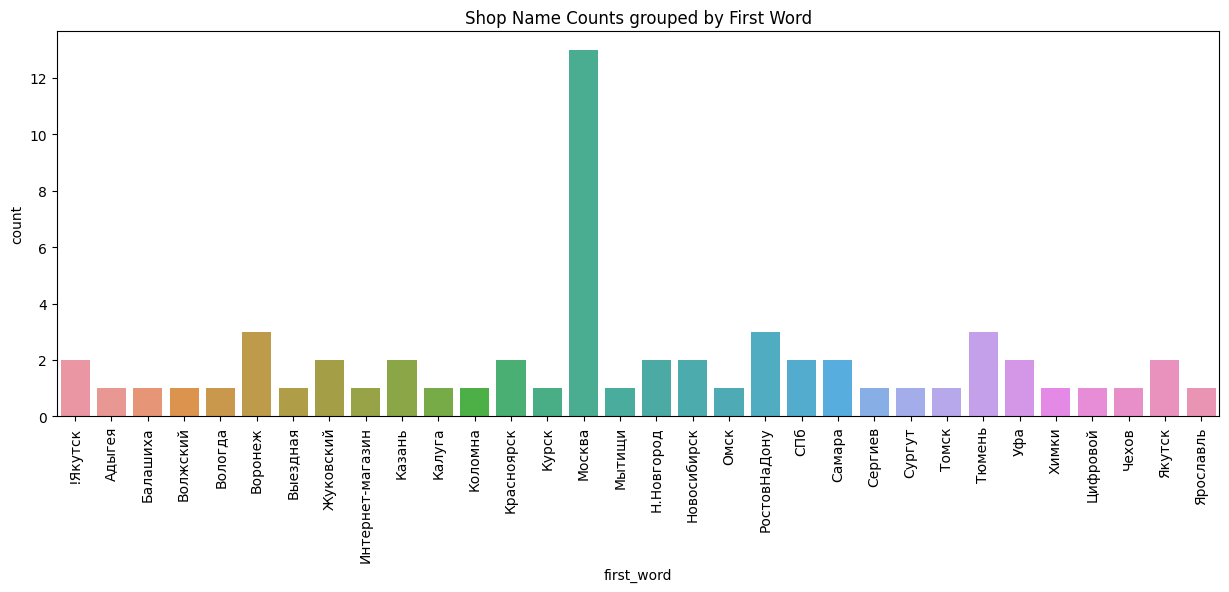

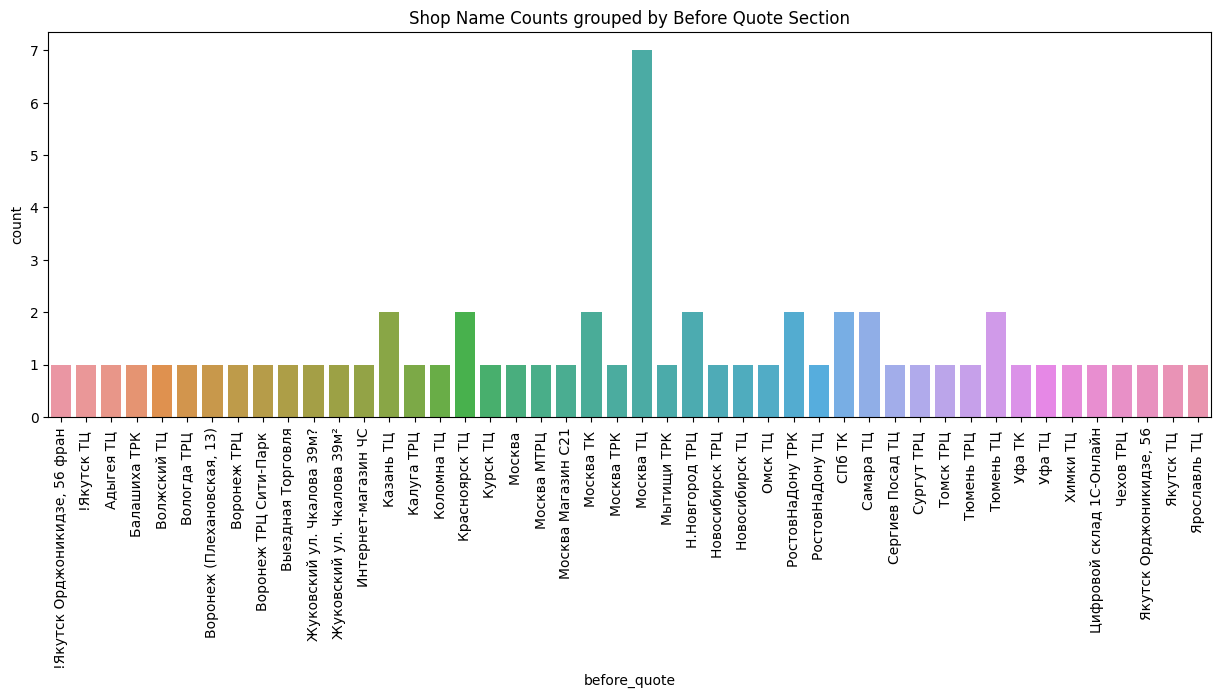

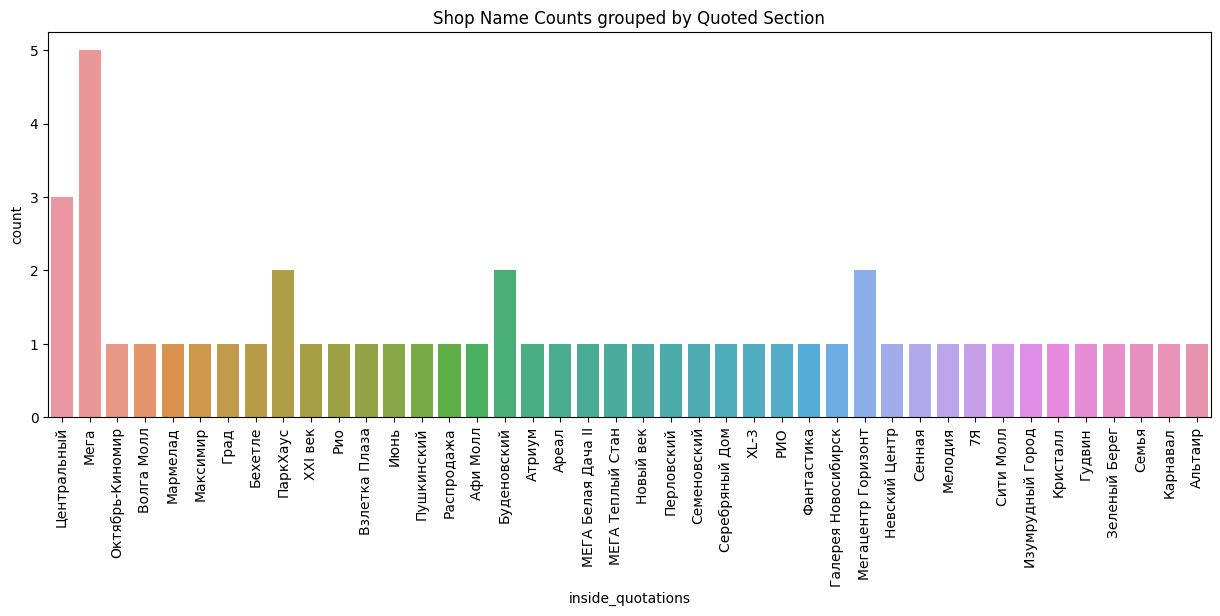

In [45]:
# 1. first word
shops_cleaned = shops.copy()
shops_cleaned['cleaned_name'] = shops_cleaned['shop_name'].replace(r'\"', '', regex=True)
shops_cleaned['first_word'] = shops_cleaned['cleaned_name'].str.split().str[0]

fig = plt.figure(figsize=(15,5))
sns.countplot(data=shops_cleaned, x='first_word')
plt.xticks(rotation=90)
plt.title('Shop Name Counts grouped by First Word');

# 2. before quotations
shops_cleaned['before_quote'] = shops_cleaned['shop_name'].str.extract(r'^([^"]*)')
fig = plt.figure(figsize=(15,5))
sns.countplot(data=shops_cleaned, x='before_quote')
plt.xticks(rotation=90)
plt.title('Shop Name Counts grouped by Before Quote Section');

# 3. inside quotations
shops_cleaned['inside_quotations'] = shops_cleaned['shop_name'].str.extract(r'"(.*?)"')
fig = plt.figure(figsize=(15,5))
sns.countplot(data=shops_cleaned, x='inside_quotations')
plt.xticks(rotation=90)
plt.title('Shop Name Counts grouped by Quoted Section');

Finding:

The first word in shop name is often the location (like the city). The part before the quote in general tend to be the city, plus something like ТЦ (shopping center) or ТРЦ (mall).

The part inside quotations differs, a few words when translated yielded Central, Marmalade, a company name, and a chain of malls. It could give additional info about the type of shop.

# Q3: Exploring Train

# Items: 22170
# Stores: 60
# Items in train: 21807
# Stores in train: 60
# Missing items: 363


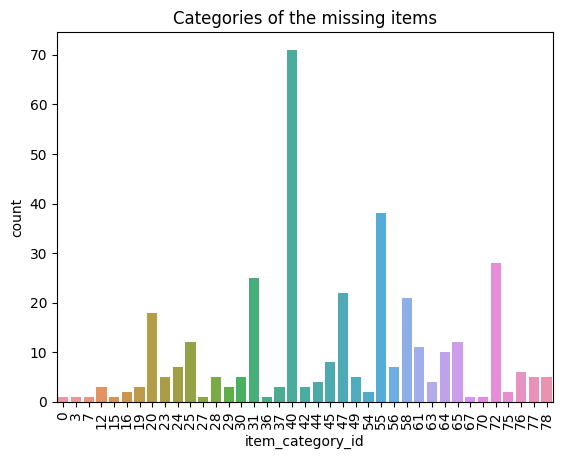

In [60]:
# What items / stores are in train? Are any missing?

print("# Items:", len(items))
print("# Stores:", len(shops))

print("# Items in train:", len(train['item_id'].unique()))
print("# Stores in train:", len(train['shop_id'].unique()))

missing_items = pd.Index(items['item_id']).difference(train['item_id'].unique())
print("# Missing items:", len(missing_items))

missing_categories = items.loc[missing_items, 'item_category_id']
sns.countplot(x=missing_categories)
plt.xticks(rotation=90)
plt.title('Categories of the missing items');

Start date: 2013-01-01 00:00:00
End date: 2015-10-31 00:00:00


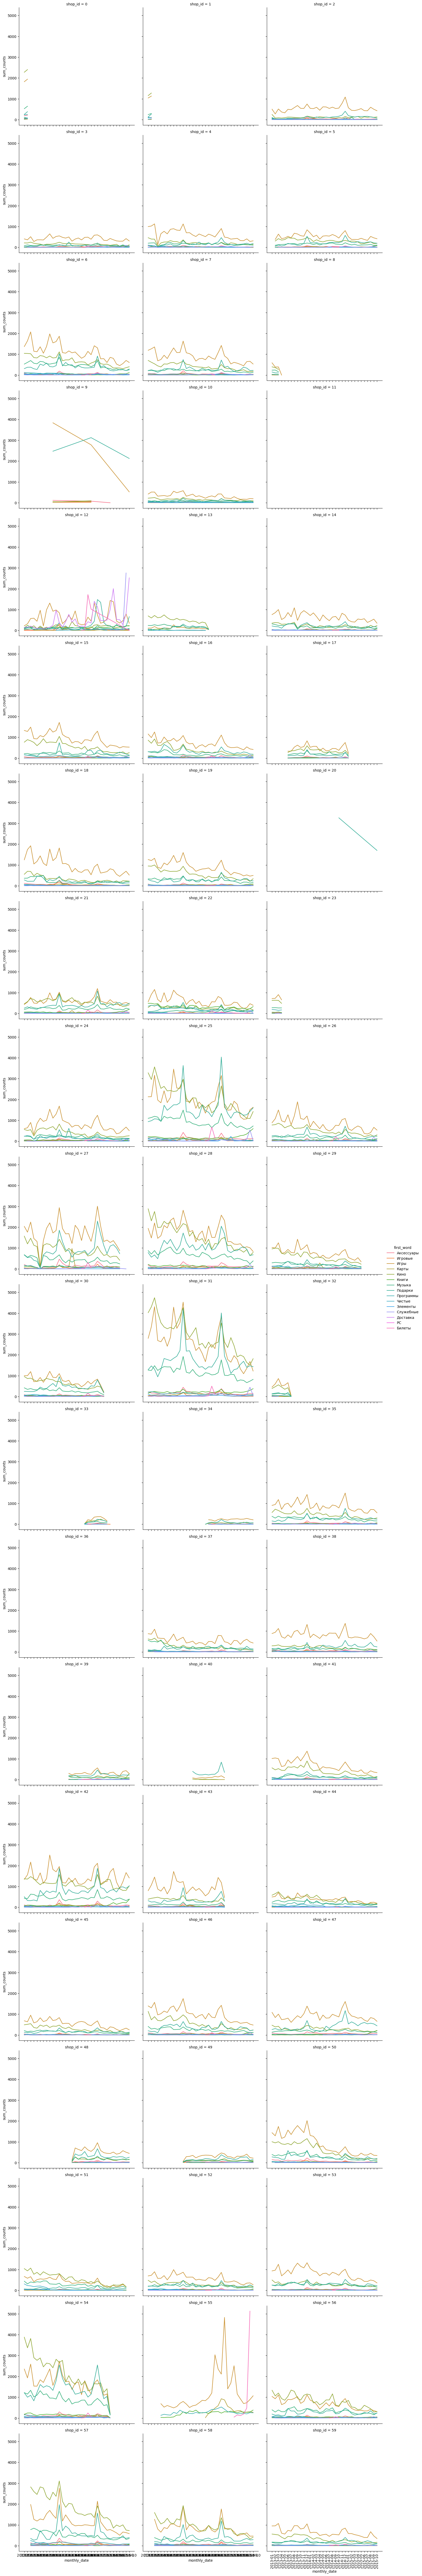

In [122]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Look at general sales over time
combined = train.merge(right=items, on='item_id', how='left').merge(categories_cleaned, on='item_category_id')
combined['parsed_date'] = pd.to_datetime(combined['date'], format='%d.%m.%Y')
combined['month'] = combined['parsed_date'].dt.month
combined['year'] = combined['parsed_date'].dt.year
combined['item_sales'] = combined['item_price'] * combined['item_cnt_day']

start_day = combined['parsed_date'].min()
end_day = combined['parsed_date'].max()
print("Start date:", start_day)
print("End date:", end_day)

combined['monthly_date'] = combined['parsed_date'].dt.to_period('M')
combined.head()
monthly_sales = combined.groupby(by=['monthly_date', 'shop_id', 'first_word'])['item_cnt_day'].sum().to_frame('sum_counts').reset_index()
monthly_sales['monthly_date'] = monthly_sales['monthly_date'].astype(str)
sns.relplot(data=monthly_sales, x='monthly_date', y='sum_counts', col='shop_id', col_wrap=3, kind='line', hue='first_word', ci=None)
plt.xticks(rotation=90);

# Q4: What exactly are we predicting

In [104]:
test = pd.read_csv(DIRECTORY + 'test.csv')
print("# Shops:", len(test['shop_id'].unique()))
print("# Items:", len(test['item_id'].unique()))
print("Test length:", len(test))

# Shops: 42
# Items: 5100
Test length: 214200


In [121]:
# Why only 42/60 shops, why only 5100/22k items?
# Check how many shops/items have sales in the last month

date_barrier = combined['parsed_date'].max() - pd.Timedelta('14D')
lw_combined = combined[combined['parsed_date'] >= date_barrier]
print("# Store w/ sales last 2w:", len(lw_combined['shop_id'].unique()))
print("# items w/ sales last 2w:", len(lw_combined['item_id'].unique()))

# Store w/ sales last 2w: 42
# items w/ sales last 2w: 4251


In [130]:
# What is the intersection of the shops and stores in Test vs. last 2 weeks of Train
# We are only looking at stores which are "in business"
# What about items? Are the items still getting sales?

test_shops = test['shop_id'].unique()
test_items = test['item_id'].unique()
                 
train_shops = lw_combined['shop_id'].unique()
train_items = lw_combined['item_id'].unique()

shop_dif = pd.Index(test_shops).difference(train_shops)
test_not_train = pd.Index(test_items).difference(train_items)
train_not_test = pd.Index(train_items).difference(test_items)

print("Test shops - Train shops:", len(shop_dif))
print("Test items - Train items:", len(test_not_train))
print("Train items - Test items:", len(train_not_test))

Test shops - Train shops: 0
Test items - Train items: 1633
Train items - Test items: 784


item_id
2403     30.0
2404     26.0
1929     23.0
6936     22.0
16569     9.0
Name: item_cnt_day, dtype: float64

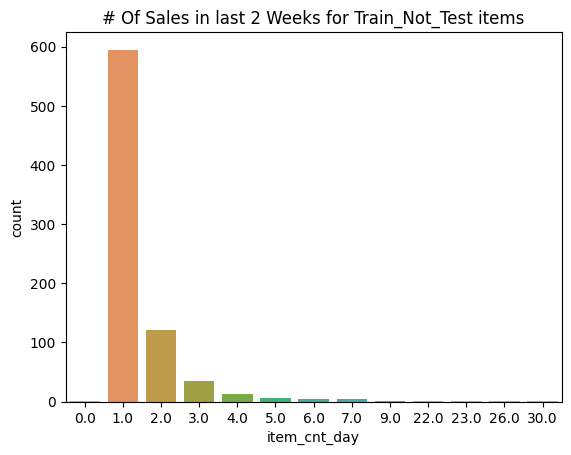

In [138]:
train_not_test_counts = lw_combined[lw_combined['item_id'].isin(train_not_test)].groupby('item_id')['item_cnt_day'].sum()
sns.countplot(train_not_test_counts)
plt.title('# Of Sales in last 2 Weeks for Train_Not_Test items')
train_not_test_counts.sort_values(ascending=False).head(5)

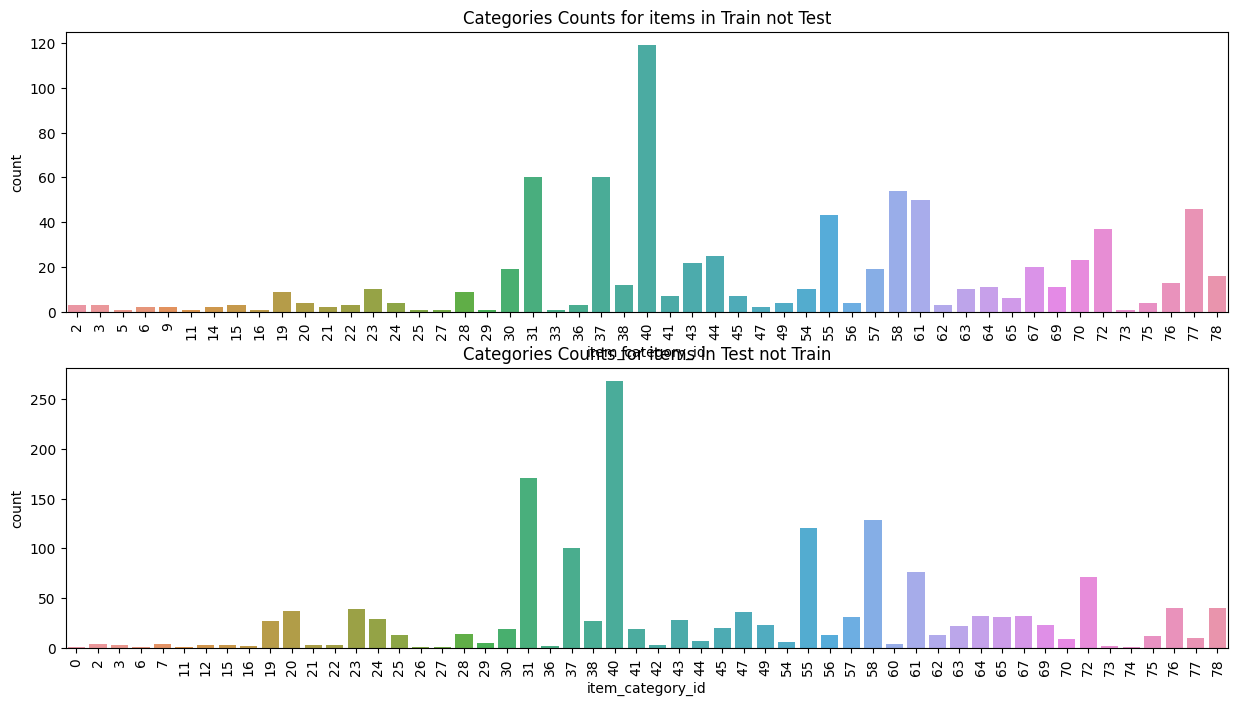

In [156]:
# What are the categories of train_not_test and test_not_train items

train_not_test_categories = items[items['item_id'].isin(train_not_test)]['item_category_id']
fig = plt.figure(figsize=(15,8))

sns.countplot(x=train_not_test_categories, ax=fig.add_subplot(211))
plt.xticks(rotation=90);
plt.title('Categories Counts for items in Train not Test')

test_not_train_categories = items[items['item_id'].isin(test_not_train)]['item_category_id']
sns.countplot(x=test_not_train_categories, ax=fig.add_subplot(212))
plt.title('Categories Counts for items in Test not Train')
plt.xticks(rotation=90);